### CNN

### Import libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [2]:
# Load data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [3]:
# Define stop words and lemmatizer for text cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

# Apply preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)
X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

# Download and load GloVe embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

from google.colab import drive
drive.mount('/content/drive')

# Load GloVe embeddings
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

Mounted at /content/drive


### Basic training module

In [4]:
# Define CNN model architecture
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(title_embedding)
title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)
title_flatten = Flatten()(title_maxpool)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(description_embedding)
description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)
description_flatten = Flatten()(description_maxpool)

merged = Concatenate()([title_flatten, description_flatten])
dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1,
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7814 - loss: 0.6403 - val_accuracy: 0.8625 - val_loss: 0.3802
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8738 - loss: 0.3646 - val_accuracy: 0.8752 - val_loss: 0.3489
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8809 - loss: 0.3401 - val_accuracy: 0.8742 - val_loss: 0.3456
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8872 - loss: 0.3193 - val_accuracy: 0.8773 - val_loss: 0.3393
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8940 - loss: 0.3012 - val_accuracy: 0.8780 - val_loss: 0.3314


### Testing Module 1 (Base Model)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Baseline Test Accuracy: 0.8820
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1900
           1       0.93      0.95      0.94      1900
           2       0.85      0.83      0.84      1900
           3       0.84      0.88      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



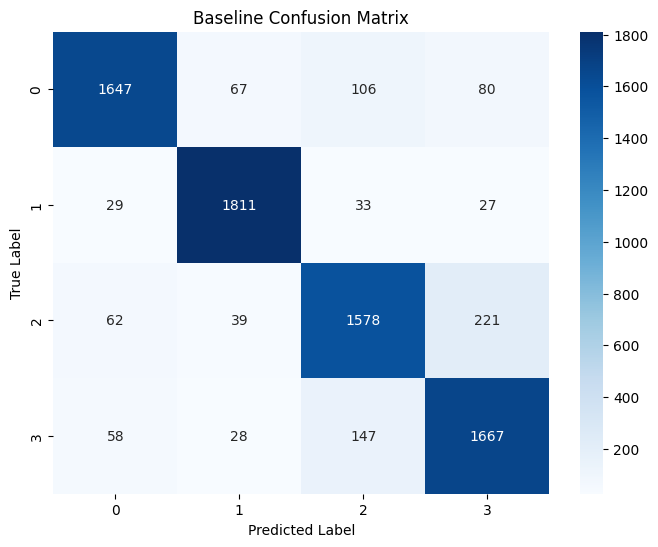

In [5]:
# Evaluate baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [6]:
def model_builder(trial):
    # Define hyperparameters for optimization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    filters = trial.suggest_int('filters', 64, 256)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Define CNN model structure with Optuna parameters
    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(title_embedding)
    title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)
    title_flatten = Flatten()(title_maxpool)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(description_embedding)
    description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)
    description_flatten = Flatten()(description_maxpool)

    merged = Concatenate()([title_flatten, description_flatten])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 19:21:24,548] A new study created in memory with name: no-name-37b249e9-30ef-496a-b6ca-f9ba69d56362


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8489 - loss: 0.4287 - val_accuracy: 0.8783 - val_loss: 0.3327
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9021 - loss: 0.2793 - val_accuracy: 0.8874 - val_loss: 0.3101
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9247 - loss: 0.2132 - val_accuracy: 0.8882 - val_loss: 0.3260
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8872 - loss: 0.3462


[I 2024-10-29 19:21:52,704] Trial 0 finished with value: 0.8876315951347351 and parameters: {'dropout_rate': 0.13428643790840444, 'learning_rate': 0.0003207654654603091, 'filters': 212, 'kernel_size': 3, 'num_units': 105}. Best is trial 0 with value: 0.8876315951347351.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8331 - loss: 0.4783 - val_accuracy: 0.8771 - val_loss: 0.3411
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8906 - loss: 0.3139 - val_accuracy: 0.8848 - val_loss: 0.3167
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9059 - loss: 0.2664 - val_accuracy: 0.8864 - val_loss: 0.3166
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8876 - loss: 0.3336


[I 2024-10-29 19:22:25,159] Trial 1 finished with value: 0.8871052861213684 and parameters: {'dropout_rate': 0.22421082935974013, 'learning_rate': 8.4670951627142e-05, 'filters': 216, 'kernel_size': 3, 'num_units': 446}. Best is trial 0 with value: 0.8876315951347351.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8250 - loss: 0.4972 - val_accuracy: 0.8763 - val_loss: 0.3427
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8876 - loss: 0.3215 - val_accuracy: 0.8838 - val_loss: 0.3271
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9033 - loss: 0.2769 - val_accuracy: 0.8880 - val_loss: 0.3120
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8910 - loss: 0.3196


[I 2024-10-29 19:22:56,611] Trial 2 finished with value: 0.8893421292304993 and parameters: {'dropout_rate': 0.2912532900042225, 'learning_rate': 9.832780773594361e-05, 'filters': 184, 'kernel_size': 3, 'num_units': 258}. Best is trial 2 with value: 0.8893421292304993.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8636 - loss: 0.3931 - val_accuracy: 0.8940 - val_loss: 0.2940
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9117 - loss: 0.2510 - val_accuracy: 0.8930 - val_loss: 0.2939
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9320 - loss: 0.1891 - val_accuracy: 0.8851 - val_loss: 0.3251
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9018 - loss: 0.3097


[I 2024-10-29 19:23:30,630] Trial 3 finished with value: 0.8973684310913086 and parameters: {'dropout_rate': 0.25782838864922014, 'learning_rate': 0.0009121907304126861, 'filters': 227, 'kernel_size': 4, 'num_units': 504}. Best is trial 3 with value: 0.8973684310913086.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7822 - loss: 0.6199 - val_accuracy: 0.8702 - val_loss: 0.3696
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8712 - loss: 0.3704 - val_accuracy: 0.8752 - val_loss: 0.3522
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8794 - loss: 0.3453 - val_accuracy: 0.8762 - val_loss: 0.3462
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8741 - loss: 0.3640


[I 2024-10-29 19:24:00,688] Trial 4 finished with value: 0.8755263090133667 and parameters: {'dropout_rate': 0.3586718138420352, 'learning_rate': 3.4281622360638407e-05, 'filters': 152, 'kernel_size': 3, 'num_units': 251}. Best is trial 3 with value: 0.8973684310913086.


Best Trial: FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.8973684310913086], datetime_start=datetime.datetime(2024, 10, 29, 19, 22, 56, 612280), datetime_complete=datetime.datetime(2024, 10, 29, 19, 23, 30, 630203), params={'dropout_rate': 0.25782838864922014, 'learning_rate': 0.0009121907304126861, 'filters': 227, 'kernel_size': 4, 'num_units': 504}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'filters': IntDistribution(high=256, log=False, low=64, step=1), 'kernel_size': IntDistribution(high=5, log=False, low=3, step=1), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=3, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8644 - loss: 0.3890 - val_accuracy: 0.8928 - val_loss: 0.3013
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9118 - loss: 0.2521 - val_accuracy: 0.8888 - val_loss: 0.3101
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9326 - loss: 0.1862 - val_accuracy: 0.8874 - val_loss: 0.3305
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9488 - loss: 0.1381 - val_accuracy: 0.8864 - val_loss: 0.3916
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9643 - loss: 0.0976 - val_accuracy: 0.8834 - val_loss: 0.4224
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Final Test Accuracy: 0.8905
Final Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1900
           1       0.96      0.95      0.96      1900
           2       0.84      0.87      0.85      1900
           3       0.88      0.84      

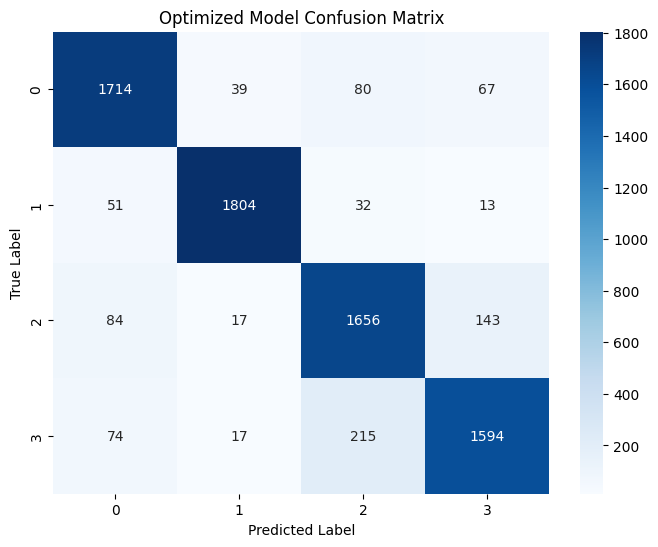

In [7]:
# Load the best model from Optuna optimization
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Evaluate optimized model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix for optimized model
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized Model Confusion Matrix')
plt.show()